# P3 - Notebook 1/2 :: Dataset cleaning

## Table of content

1. **[Application idea](#app_idea)**
2. **[Initialization and data loading](#init)**
3. **[Filtering on french products](#french)**
4. **[Pre-selecting variables](#preselection)**
5. **[Analysing the pre-selected variables](#preselection-analysis)**
    1. [Nutritional scores](#nutriscores)
    2. [Categories and tags columns](#categories)
    3. [Organic label](#organic_label)
    4. [Energy columns](#energy-columns)
    5. [Salt and sodium columns](#salt_sodium)
6. **[Treating aberrant and atypical values](#aberrant_atypical)**
    1. [Nutritional scores](#atypical_nutriscores)
    2. [Energy column](#atypical_energies)
    3. [Nutritional columns](#atypical_nutritional)
7. **[Treating missing values](#missing_values)**
    1. [Removing empty lines](#missing_empty_lines)
    2. [Removing product with no name](#empty_product_names)
    3. [Nutritional columns](#empty_nutritional)
    4. [Other columns](#missing_others)
8. **[Exporting data](#export)**

## 1. Application idea <a name="app_idea"></a>
The idea here is to create an app that, from a given product, will : 
* Suggest similar products but organic (if it's possible) or with a better nutriscore.
* Display all the products nutritional information using spider charts (more complete than just the score).

## 2. Notebook initialisation and data loading<a name="init"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import math

from common_functions import *

sns.set()
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('data/data.csv', sep='\t', low_memory=False)

## 3. Keeping french products only<a name="french"></a>
The goal of our application is to suggest similar products. Moreover we want to use the french nutriscore as much as possible. That's why we decide here to **keep only the french products** for our study.

To achieve that, let's we have a look to the **countries** column and we can notice that each country can be present on at least 2 different forms that are case insensitive : 
* The country name itself : "France" or "france"
* The country code ("fr" for France) following another country name/code (separated by a colon) : "en:fr" for example.

So we use regular expressions to isolate these 2 cases and filter our countries to keep french products only.

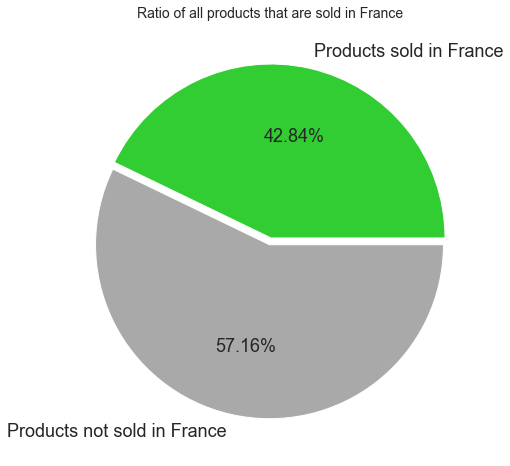

In [3]:
# Defining a variable that will show how many lines we remove with each filter
applied_filters = {'Initial dataset': len(data)}

# Filtering data
data['sold_in_france'] = data['countries'].str.contains('(?:France)|(?::fr)', case=False, regex=True)

# Visualizing on a pie chart the ratio of products sold in France
total_french_products = len(data[data['sold_in_france'] == True])
total_not_french_products = len(data) - total_french_products

pie, ax = plt.subplots(figsize=[10,8])
plt.pie(x=[total_french_products, total_not_french_products], 
        autopct="%.2f%%", 
        labels=["Products sold in France", "Products not sold in France"], 
        colors=['limegreen', 'darkgrey'],
        explode=[0.02]*2,
        textprops={'size': 18})
plt.title("Ratio of all products that are sold in France", fontsize=14)

data_france = data[data['sold_in_france'] == True].copy()

applied_filters['French products'] = len(data_france)

## 4. Pre-selecting our variables<a name="preselection"></a>
We use the [variables liste](https://world.openfoodfacts.org/data/data-fields.txt) available on the OFF website.

To create our application, we would like to have these kinds of variables : 
* The **product name** 
* Various **nutritional information** to create our spider charts
* The **labels** to find an eventual organic label
* The **product french nutriscore** to compare products
* The **product categories** in order to understand which kind of product 
* Eventually a **product image** to make the display more 

### 4.1 Exploring the percentages of missing values for each column
Let's calculate the percentage of filled values for every variable of the dataset.

(0.0, 129.15)

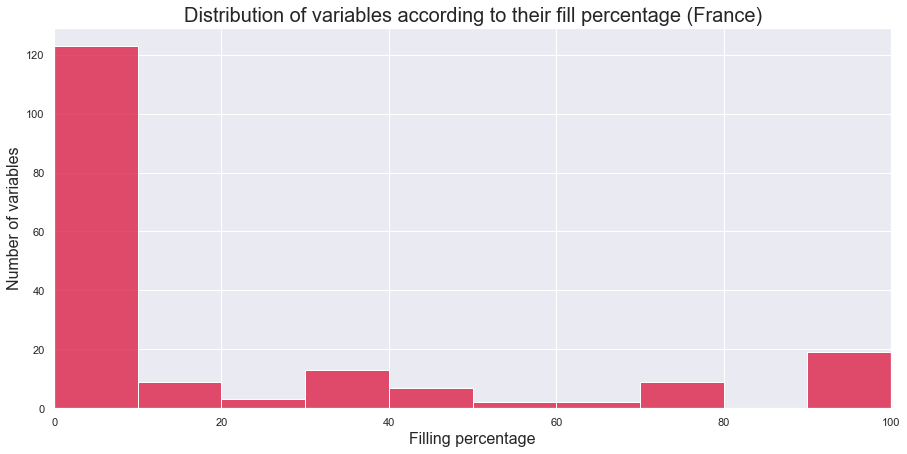

In [4]:
# Let's show the ditribution of our variables filling to get the best ones
filled_data = data_france.notnull().sum()
filled_data = filled_data * 100 / len(data_france)
filled_data = filled_data.sort_values(ascending=False)

# We plot the distribution of the filling percentage on a histogramm 
plt.figure(figsize=(15,7))
sns.histplot(filled_data, bins=10, color="crimson")
plt.title("Distribution of variables according to their fill percentage (France)", size=20)
plt.xlabel("Filling percentage", size=16)
plt.ylabel("Number of variables", size=16)
axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,None])

**Conclusion** : most of the variables are less than 10% filled, so they are very uninteresting for our analysis.

Now let's have a look at the most filled variables of the dataset.

### 4.2 Exploring data filling / NaN values

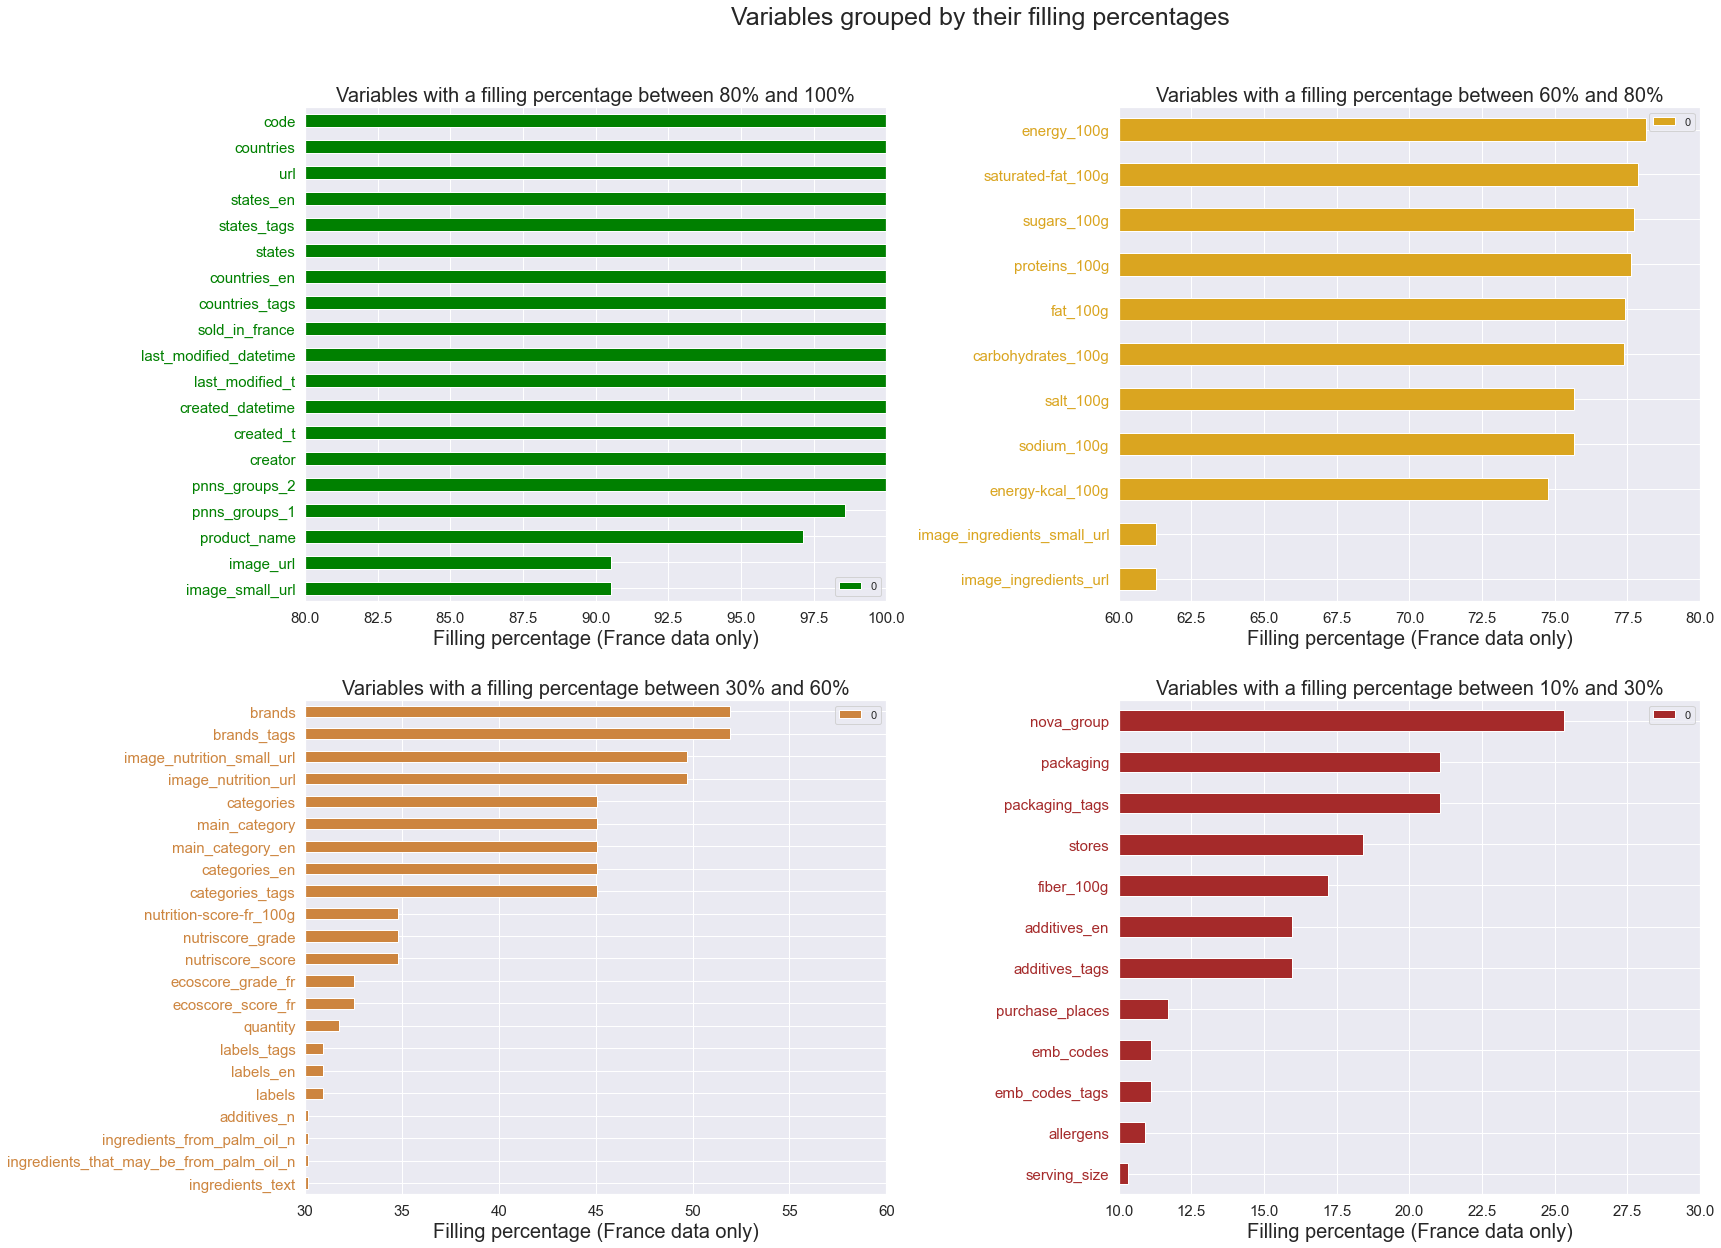

In [5]:
fig, axes = plt.subplots(figsize=(25,20), nrows=2, ncols=2)
fig.suptitle('Variables grouped by their filling percentages', fontsize=25, y=0.95)
fig.subplots_adjust(hspace=0.2, wspace=0.4)


plot_variables_filling_percentage(filled_data, 80, 100, ax=axes[0][0], color="green")
plot_variables_filling_percentage(filled_data, 60, 80, ax=axes[0][1], color="goldenrod")
plot_variables_filling_percentage(filled_data, 30, 60, ax=axes[1][0], color="peru")
plot_variables_filling_percentage(filled_data, 10, 30, ax=axes[1][1], color="brown")

**80-100% filled columns** : 
* all the variables that are 100% filled are mostly technicial variables of OpenFoodFacts (product code, datetimes, editors, ...)
* the **pnns** variables contains food categories created by the french government but it seems strange that they are as much filled. We are going to check it.
* we have, as we wanted to, a **product name**, an **url** and an **image_url** (which is as filled as the **image_small_url** that we can use to lightened the application results load.

**60-80% filled columns** : 
* the product ingredient image url, which are not useful for our application
* many nutritional information that can be used to display our nutritional spider charts

But the question is : **do all the nutritional informations are present here** ? We can notice that they all ends with "**_100g**" so let's find all variables with this pattern that are not present in the list above.

**30-60% filled columns** : 
* there are a **main_category**, a **categories** and a **categories_tags** variables that can be really helpful if the *pnns* variables are not filled enough
* we find again the **nutrition-score-fr_100g** we met before, along with a **nutriscore_score** and a **nutriscore_grade** that should be linked
* the **labels** in order to find out, for example, some organic products
* somes variables can inform us about the presence of **ingredients from palm oil** that we could use to discriminate 2 products (find out which one is more healthy)

**16-30% filled columns** :

Even if these columns are not filled enough, one of them is interesting and could be helpful for the rest of our analysis : 
* the **fiber_100** that we will include in our spider chart only if it is provided

Now let's check the values inside the pnns columns.

#### Validating the PNNS columns

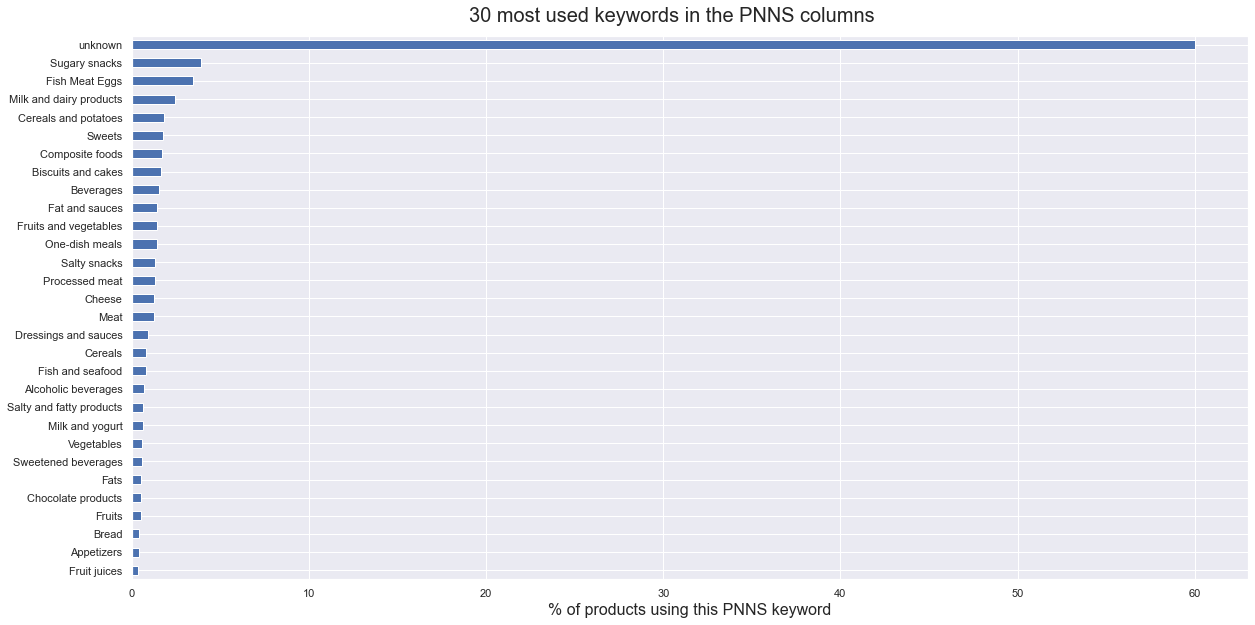

In [6]:
pnns = (pd.concat([data_france['pnns_groups_1'], data_france['pnns_groups_2']])).value_counts()

# The *2 factor is present because we concatenate 2 PNNS columns so we have twice the lenght of the initial DF
pnns = pnns * 100 / (len(data_france) * 2)

pnns_plot_size = 30
pnns[:pnns_plot_size].plot(kind='barh', figsize=(20,10))
plt.gcf().suptitle(str(pnns_plot_size) + " most used keywords in the PNNS columns", fontsize=20, y=0.92)
plt.gca().set_xlabel("% of products using this PNNS keyword", fontsize=16)
plt.gca().invert_yaxis()

We notice that the "**unknown**" keyword it used 80% of the time. So, in fact, the PNNS variables are 80% empty, so we are going to replace the "unknown" values by NaN values for the rest of the analysis.

In [7]:
data_france.loc[data_france['pnns_groups_1'] == 'unknown', 'pnns_groups_1'] = np.nan
data_france.loc[data_france['pnns_groups_2'] == 'unknown', 'pnns_groups_2'] = np.nan

# The average filling percentage of PNNS columns should be around 40% now
100 * (data_france['pnns_groups_1'].notnull().sum() + data_france['pnns_groups_2'].notnull().sum()) / (2 * len(data_france))

39.269376250530335

### 4.3 Final list of the pre-selected variables

In [8]:
display_variables = ['url', 'product_name', 'image_small_url']
category_variables = ['main_category', 'categories', 'categories_tags']
label_variables = ['labels', 'labels_tags']
nutriscore_variables = ['nutrition-score-fr_100g', 'nutriscore_score', 'nutriscore_grade']
calculation_variables = ['energy_100g', 'saturated-fat_100g', 'sugars_100g', 'proteins_100g', 'fat_100g',
                        'carbohydrates_100g', 'salt_100g', 'sodium_100g', 'energy-kcal_100g', 'fiber_100g']

## 5. Analysing our pre-selected variables<a name="preselection-analysis"></a>
In this part, we will try to answer these questions :
* **Are all the 3 "nutriscore" columns essential** or can we reduce them to keep only one of them ?
* Same question for the categories and labels ?
* Can we **determine the percentage of fibers by using the other columns** ?

### 5.1 Comparing nutritional score indicators<a name="nutriscores"></a>

Text(0.5, 1.05, 'Nutrition score distribution and correlation to nutriscore_score column')

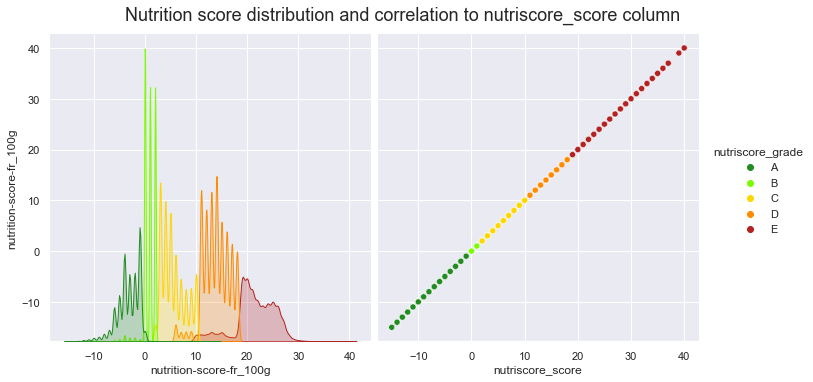

In [9]:
data_france.loc[:, 'nutriscore_grade'] = data_france['nutriscore_grade'].str.upper()
nutriscore_data = data_france[nutriscore_variables]
pairplot = sns.pairplot(nutriscore_data, 
             x_vars=["nutrition-score-fr_100g", "nutriscore_score"],
             y_vars=["nutrition-score-fr_100g"],
             hue='nutriscore_grade', 
             hue_order=['A', 'B', 'C', 'D', 'E'],
             palette=NUTRIGRADE_COLORS,
             height=5)
pairplot.fig.suptitle('Nutrition score distribution and correlation to nutriscore_score column', y=1.05, fontsize=18)

These charts give us many informations.
* The **nutriscore_score and and nutrition-score-fr_100g are the same**. We notice a perfect straight line between both, with a 45° angle and a 0 origin value. It means that our 2 columns have the same values.


* We also notice the different colors on these straight lines that **confirm the french nutriscore grade slices** : 
 * **Grade A** : from -15 to -1
 * **Grade B** : from 0 to 2
 * **Grace C** : from 3 to 10
 * **Grade D** : from 11 to 18
 * **Grade E** : from 19 to 40
 
 
* The 2 histograms shows the **nutriscore_grade errors** : the different colors should be perfectly separated according to the slices above, but we can see that they are not.


**CONCLUSION** : we can keep only one of these 3 columns, and **we will keep the nutrition-score-fr_100g** as it a little more filled. We will reassign a nutriscore-grade using the official nutriscore slices.

But before removing the *nutriscore_score* columns, let's check if they are some products for which this column is filled and not the *nutrition-score-fr_100g* : 

In [10]:
len(data_france[(data_france['nutriscore_score'].notnull()) & (data_france['nutrition-score-fr_100g'].isnull())])

0

Our choice is good, and there is no need to merge the 2 columns.

### 5.2 Selecting one or many category column<a name="categories"></a>
We pre-selected many category columns, now we would like to explore them and see if one of them seems better than the others.

First of let's compare their filling percentages : we notice that the **categories** are all filled ad approximately 45% which is pretty good. 

Now let's have a look at what's inside these columns : 

In [11]:
categories_data = data_france[category_variables].dropna(how="all")
categories_data

main_category  \
4                         en:mustards   
5                              fr:xsf   
14                   fr:pate-d-amende   
15       en:seasoned-shredded-carrots   
24                    en:coconut-pies   
...                               ...   
1821066               en:gingerbreads   
1821067         en:ground-beef-steaks   
1821070             en:sweet-fritters   
1821073         en:ground-beef-steaks   
1821080                 en:toothpaste   

                                                categories  \
4                  Epicerie, Condiments, Sauces, Moutardes   
5                                                      Xsf   
14                                           Pâte d'amende   
15       Plats préparés, Légumes préparés, Carottes râp...   
24        Tartes, Tartes sucrées, Tartes à la noix de coco   
...                                                    ...   
1821066                                    en:gingerbreads   
1821067  Viandes, Bœuf, Steaks, Steaks de bœuf, Steaks ...   
1821070             Snacks, Snacks sucrés, Beignets sucrés   
1821073  Viandes, Bœuf, Steaks, Steaks de bœuf, Steaks ...   
1821080   Non food products, Open Beauty Facts, Toothpaste   

                                           categories_tags  
4         en:groceries,en:condiments,en:sauces,en:mustards  
5                                                   fr:xsf  
14                                        fr:pate-d-amende  
15       en:meals,en:prepared-vegetables,en:grated-carr...  
24                   en:pies,en:sweet-pies,en:coconut-pies  
...                                                    ...  
1821066              en:biscuits-and-cakes,en:gingerbreads  
1821067  en:meats,en:beef,en:steaks,en:beef-steaks,en:g...  
1821070        en:snacks,en:sweet-snacks,en:sweet-fritters  
1821073  en:meats,en:beef,en:steaks,en:beef-steaks,en:g...  
1821080  en:non-food-products,en:open-beauty-facts,en:t...  

[351515 rows x 3 columns]

#### Studying categories_tags values

In [12]:
split_tags_count = (categories_data['categories_tags'].str.split(',', expand=True).stack().value_counts()).to_frame()
split_tags_count.columns = ['Nb of products']

# A tag could be used twice in a product but we do not consider this case below
split_tags_count['% of products'] = 100 * split_tags_count ['Nb of products'] / len(data_france)
split_tags_count

Nb of products  % of products
en:plant-based-foods-and-beverages          100058      12.825170
en:plant-based-foods                         86338      11.066577
en:snacks                                    51198       6.562424
en:meats                                     44388       5.689536
en:sweet-snacks                              43382       5.560590
...                                            ...            ...
fr:crevettes-bio                                 1       0.000128
fr:boudins-creoles                               1       0.000128
fr:vin-du-beaujolais                             1       0.000128
fr:rillettes-de-moules                           1       0.000128
fr:barres-d-arachides-sucrees                    1       0.000128

[19033 rows x 2 columns]

The use of each keyword is very various, between 12% and 0.0001%. We now would like to know how they are distributed

Text(106.125, 0.5, 'Number of keywords')

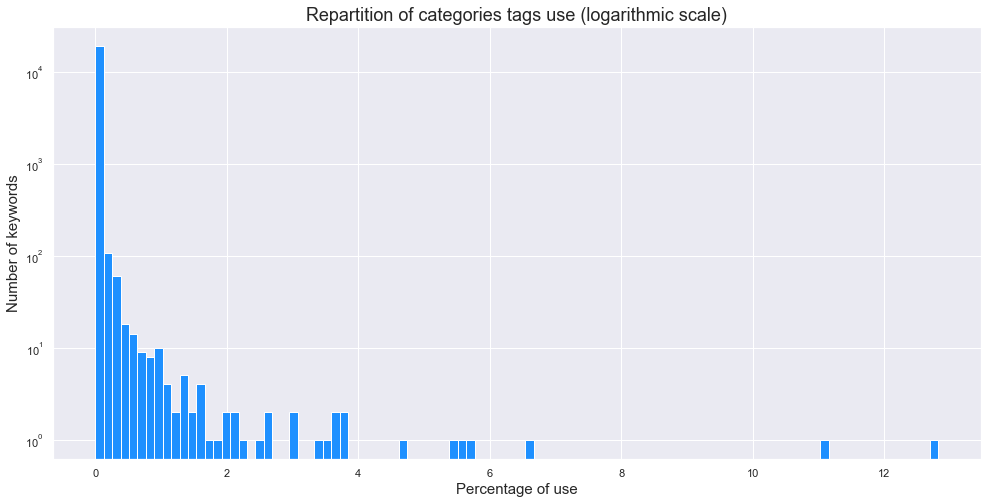

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
fig.tight_layout(pad=5.0)

# Repartition of keywords by number of uses 
split_tags_count['% of products'].plot(kind="hist", ax=ax, color="dodgerblue", logy=True, bins=100)
ax.set_title("Repartition of categories tags use (logarithmic scale)", fontsize=18)
ax.set_xlabel("Percentage of use", fontsize=15)
ax.set_ylabel("Number of keywords", fontsize=15)

In [14]:
# Counting the percentage of tags used by less than 0.0002% of the keywords
once_percentage = round(100 * len(split_tags_count[split_tags_count['Nb of products'] == 1]) / len(split_tags_count),2)
print("Percentage of tags used only once : " + str(once_percentage) + "%")

Percentage of tags used only once : 53.54%


So **53% of the tags are used only by one product**. We keep them anyway because we have no interest in replacing them by NaN.

#### Studying main_category values

Number of categories in the main_category column : 16814
Percentage of main_categories used only once : 54.24%


([<matplotlib.patches.Wedge at 0x27f3aafdd60>,
 [Text(-0.14734284982085905, 1.100177296896581, 'Used only once'),
  Text(-0.9314190658846184, -0.6037868197523235, 'Used less than 3 times'),
  Text(0.4748060269507593, -1.0033240935865315, 'Used more than 3 times')],
 [Text(-0.0809721967484, 0.6046019379341572, '54.2%'),
  Text(-0.5118609280987543, -0.3318107748188444, '9.8%'),
  Text(0.260929438234201, -0.5513763036826884, '35.9%')])

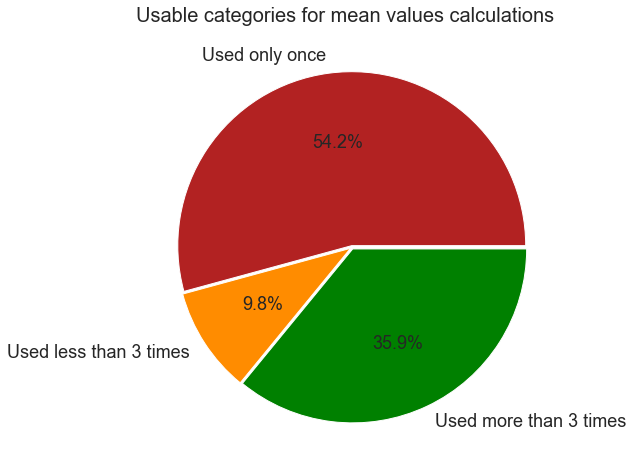

In [15]:
print("Number of categories in the main_category column : " + str(len(data_france['main_category'].unique())))

categories_count = categories_data['main_category'].value_counts().to_frame()
once_percentage = round(100 * len(categories_count[categories_count['main_category'] == 1]) / len(categories_count),2)
print("Percentage of main_categories used only once : " + str(once_percentage) + "%")

# Preparing a pie chart to show how many categories are used more than the given threshold
USE_THRESHOLD=3
pie_chart_data = {
    'Used only once': len(categories_count[categories_count['main_category'] == 1]),
    'Used less than ' + str(USE_THRESHOLD) + ' times' : len(categories_count[(categories_count['main_category'] > 1) & (categories_count['main_category'] < USE_THRESHOLD)]),
    'Used more than ' + str(USE_THRESHOLD) + ' times' : len(categories_count[categories_count['main_category'] >= USE_THRESHOLD])
}

fig = plt.figure(figsize=(8,8))
plt.suptitle("Usable categories for mean values calculations", fontsize=20, y=0.92)
plt.pie(pie_chart_data.values(), 
        labels=pie_chart_data.keys(), 
        autopct="%.1f%%", 
        explode=[0.01]*3, 
        colors=["firebrick", "darkorange", "green"],
        textprops={'size': 18})

This time again, most of the categories are used only by one product in our dataset.

We keep them anyway but we have to keep that in mind for the treatment of missing values using main category means.

### 5.3 Looking for organic label<a name="organic_label"></a>
For organic labels, we are going to add a boolean column at True if the labels contains "organic" or "bio" (to match both french and english organic names)

([<matplotlib.patches.Wedge at 0x27f5499bc10>,
 [Text(1.0482342751778575, 0.3944678749180364, 'Organic'),
  Text(0.2651358968944271, 1.0881649489751026, 'Non organic'),
  Text(-0.6314024090972574, -0.9250572943262378, 'N/A')],
 [Text(0.5802725451877426, 0.21836614504391302, '11.46%'),
  Text(0.14677165720941499, 0.6023770253255032, '19.48%'),
  Text(-0.34952633360741026, -0.5120852879305959, '69.06%')])

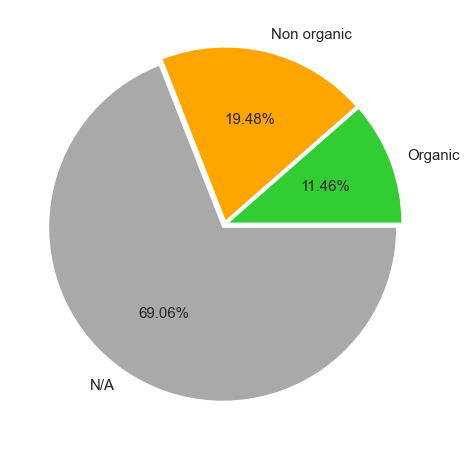

In [16]:
data_france['organic'] = data_france['labels'].str.contains('(?:organic)|(?:bio)', case=False, regex=True)
total_organic_products = len(data_france[data_france['organic'] == True])
total_non_organic_products = len(data_france[data_france['organic'] == False])
total_null_organic_products = len(data_france[data_france['organic'].isnull() == True])

plt.figure(figsize=(8,8))
plt.pie([total_organic_products, total_non_organic_products, total_null_organic_products],
        autopct="%.2f%%", 
        labels=["Organic", "Non organic", "N/A"], 
        colors=['limegreen', 'orange', 'darkgrey'],
        explode=[0.02]*3,
        textprops={'size': 15})

### 5.4 Comparing energy columns<a name="energy-columns"></a>
In this part we are going to compare the two energy columns : one in kilo-Joule (kJ) and one in kilo-calorie (kcal).

The definition of the kcal is : **1 kcal = 4.184 kJ** so let's see if we can find this ratio between our columns :

In [17]:
energy_data = data_france[['energy_100g', 'energy-kcal_100g']].copy()
energy_data['ratio'] = energy_data['energy_100g'] / energy_data['energy-kcal_100g']
energy_data[(energy_data['energy_100g'].notnull()) & (energy_data['energy-kcal_100g'].notnull())]

energy_100g  energy-kcal_100g     ratio
0             1569.0             375.0  4.184000
6               88.0              21.0  4.190476
7              251.0              60.0  4.183333
13             264.0              63.0  4.190476
15             134.0              32.0  4.187500
...              ...               ...       ...
1821065       1469.0             351.0  4.185185
1821068       1556.0             372.0  4.182796
1821070       1393.0             333.0  4.183183
1821073        548.0             131.0  4.183206
1821079          0.0               0.0       NaN

[583249 rows x 3 columns]

These 2 columns seem to be linked by **a fixed ratio around 4.18** as expected.

We are going to merge them into the *energy-kcal_100g* column using the mean ratio of the entire set, then we'll keep only this column.

In [18]:
ratio = energy_data[(energy_data['ratio'].notnull()) & (energy_data['ratio'] != np.inf)]['ratio'].mean()
data_france.loc[(data_france['energy_100g'].notnull()) & (data_france['energy-kcal_100g'].isnull()), 'energy-kcal_100g'] = data_france['energy_100g'] / ratio

### 5.7 Comparing salt and sodium columns<a name="salt_sodium"></a>
We kept both **sodium and salt** columns, but normally only one should be useful, because the sodium in a product is brought by the salt (salt contains 40% of sodium).

We are going to check that by plotting the sodium quantity as a function of the salt quantity, and then merging the 2 columns by keeping the average ratio between them.

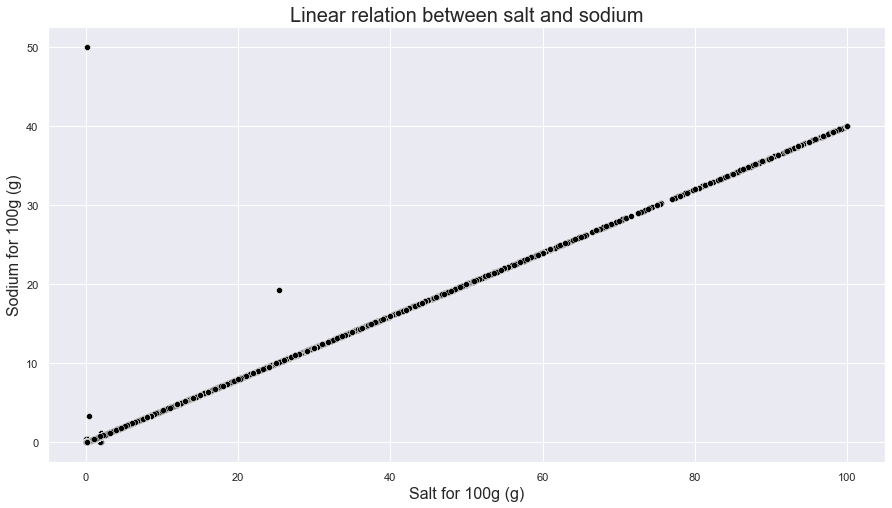

In [19]:
# Plotting salt/sodium linear relation
salt_sodium_data = data_france[(data_france['salt_100g'] <= 100) & (data_france['sodium_100g'] <= 100)].filter(['salt_100g', 'sodium_100g']).dropna(how="any")

fig = plt.figure(figsize=(15,8))
plt.gca().set_title("Linear relation between salt and sodium", fontsize=20)
plt.gca().set_xlabel("Salt for 100g (g)", fontsize=16)
plt.gca().set_ylabel("Sodium for 100g (g)", fontsize=16)
sns.scatterplot(x=salt_sodium_data['salt_100g'], y=salt_sodium_data['sodium_100g'], color="black")

# Calculating the ratio and merging the column into the salt columns
salt_sodium_ratio = data_france['sodium_100g'].mean() / data_france['salt_100g'].mean()
data_france.loc[(data_france['sodium_100g'].notnull()) & (data_france['salt_100g'].isnull()), 'salt_100g'] = data_france['sodium_100g'] / salt_sodium_ratio

## 6. Treating atypical and aberrant values<a name="aberrant_atypical"></a>

### 6.1 Filtering data columns
First of all, now we have selected our final columns, we can filter the dataframe :

In [20]:
final_columns = ['url',
                 'product_name',
                 'image_small_url',
                 'main_category',
                 'categories_tags',
                 'organic',
                 'nutrition-score-fr_100g',
                 'saturated-fat_100g',
                 'sugars_100g',
                 'proteins_100g',
                 'fat_100g',
                 'carbohydrates_100g',
                 'salt_100g',
                 'energy-kcal_100g',
                 'fiber_100g']
data_france = data_france.filter(final_columns, axis=1)

In [21]:
len(data_france['main_category'].unique())

16814

### 6.2 French nutrition score column<a name="atypical_nutriscores"></a>

In [22]:
def plot_columns_boxplots(data, columns=[], ncols=2, color="dodgerblue"):
    if len(columns) == 0:
        columns = data.columns.values
        
    if len(columns) == 1:
        plt.figure(figsize=(9,3))
        sns.boxplot(x=data[columns[0]], color=color)
        
    else:
        fig, axs = plt.subplots(figsize=(20,20), ncols=ncols, nrows=math.ceil(len(columns) / ncols))
        for index, column in enumerate(columns):
            row_index = math.floor(index / ncols)
            col_index = index % ncols
            sns.boxplot(x=data[column], ax=axs[row_index][col_index], color=color)

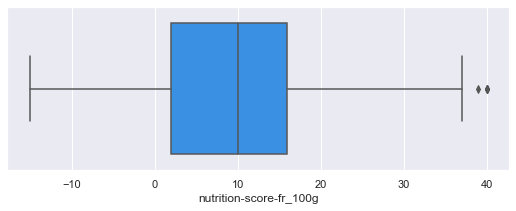

In [23]:
plot_columns_boxplots(data_france, columns=['nutrition-score-fr_100g'])

There is not atypical values for the nutrition score, they are all between -15 and 40 which is the normal definition of it.

### 6.3 Energy column<a name="atypical_energies"></a>
The energy in kcal is defined by the composition of the product : 
* 1 gram of carbohydrats = 4 kcal
* 1 gram of proteins = 4 kcal
* 1 gram of alcohol = 7 kcal
* 1 gram of fat = 9 kcal

It means that the most calorific products are the ones that contains only fat (oil, for example) and would contains 900 kcal for 100g.
So we can **clean all the values that are above 900 kcal**.

In [24]:
# This line is apart to make sure its data doesn't change while re-running the cell below
data_before = data_france['energy-kcal_100g'].copy()

<AxesSubplot:title={'center':'After cleaning'}, xlabel='energy-kcal_100g'>

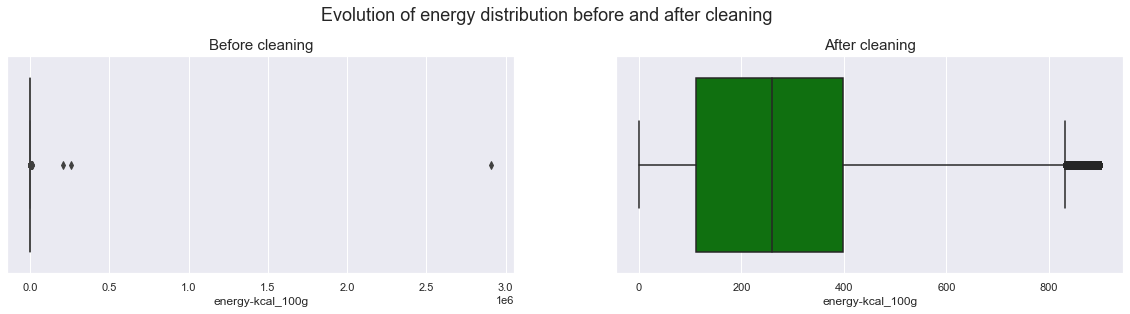

In [25]:
# Removing values above 900 kcal
data_france.loc[data_france['energy-kcal_100g'] > 900, 'energy-kcal_100g'] = np.nan

# Plotting the boxplots before and after the cleaning
fig, axs = plt.subplots(figsize=(20,4), ncols=2, nrows=1)
fig.suptitle('Evolution of energy distribution before and after cleaning', fontsize=18, y=1.05)
axs[0].set_title('Before cleaning', fontsize=15)
axs[1].set_title('After cleaning', fontsize=15)
sns.boxplot(x=data_before, ax=axs[0], color="firebrick")
sns.boxplot(x=data_france['energy-kcal_100g'], ax=axs[1], color="green")

In [26]:
# We store the data before cleaning for display and comparison
nutritional_columns = get_nutritional_columns(data_france)
nutri_data_before = data_france[nutritional_columns].copy()

#### Removing products where sum of nutrients is too high

We can impute missing nutritional values. But when the sum of all nutritional values is aberrant, we cannot determine which column contains a bad value. That why I decided to remove all columns where the sum of all nutrients is greater than 100g.

In that purpose, we don't use "saturated fats" (which are already included in the fats) and "sugars" (which are alreadu included in the carbohydrates).

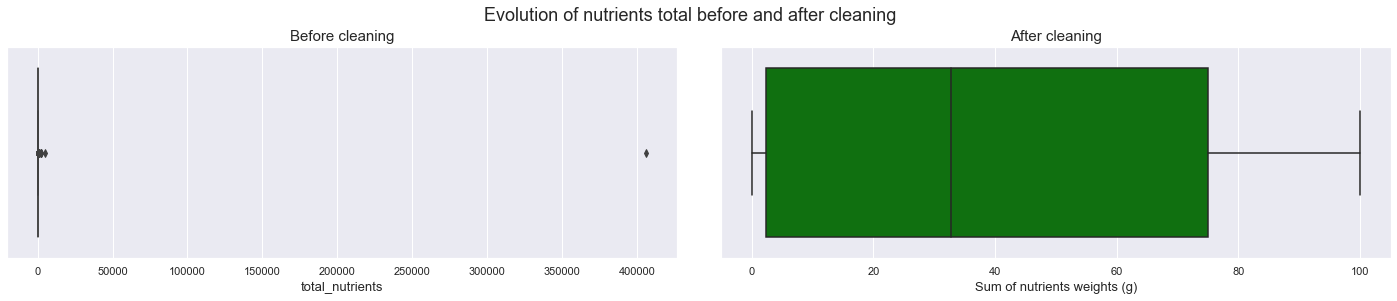

In [27]:
# Creating a new columns containing the total weight of all nutrients
nutrient_columns = get_nutritional_columns(data_france, exclude_starts=['sugars', 'saturated', 'energy', 'nutrition'])
data_france['total_nutrients'] = data_france[nutrient_columns].sum(axis=1)
nutri_data_before['total_nutrients'] = nutri_data_before[nutrient_columns].sum(axis=1)

# Preparing the plot
fig, axs = plt.subplots(figsize=(20,4), ncols=2)
fig.suptitle('Evolution of nutrients total before and after cleaning', fontsize=18)
fig.tight_layout(pad=1.0)

# Plotting the data before cleaning
axs[0].set_title("Before cleaning", fontsize=15)
axs[0].set_xlabel("Sum of nutrients weights (g)", fontsize=13)
sns.boxplot(x=nutri_data_before['total_nutrients'], color="firebrick", ax=axs[0]) 

# Removing the aberrant values (inf to 0 or sup to 100)
data_france = data_france[(data_france['total_nutrients'] <= 100) & (data_france['total_nutrients'] >= 0)]

# Plotting the boxplot after cleaning
sns.boxplot(x=data_france['total_nutrients'], color="green", ax=axs[1]) 
axs[1].set_title("After cleaning", fontsize=15)
axs[1].set_xlabel("Sum of nutrients weights (g)", fontsize=13)

# Removing the useless column
data_france = data_france.drop('total_nutrients', axis="columns")

# Saving the new data length for filter history
applied_filters['Total nutrients \n > 100g'] = len(data_france)

#### Removing aberrant values per column
In this part, we are going to boxplot all nutritional columns, before and after removing the aberrant values (we set them to NaN).

We consider as aberrant a value lower than 0g or higher than 100g.

### 6.4 Nutritional columns<a name="atypical_nutritional"></a>
We call here "nutritional columns" all the columns containing a nutritional information for 100g of product, including the french nutriscore.

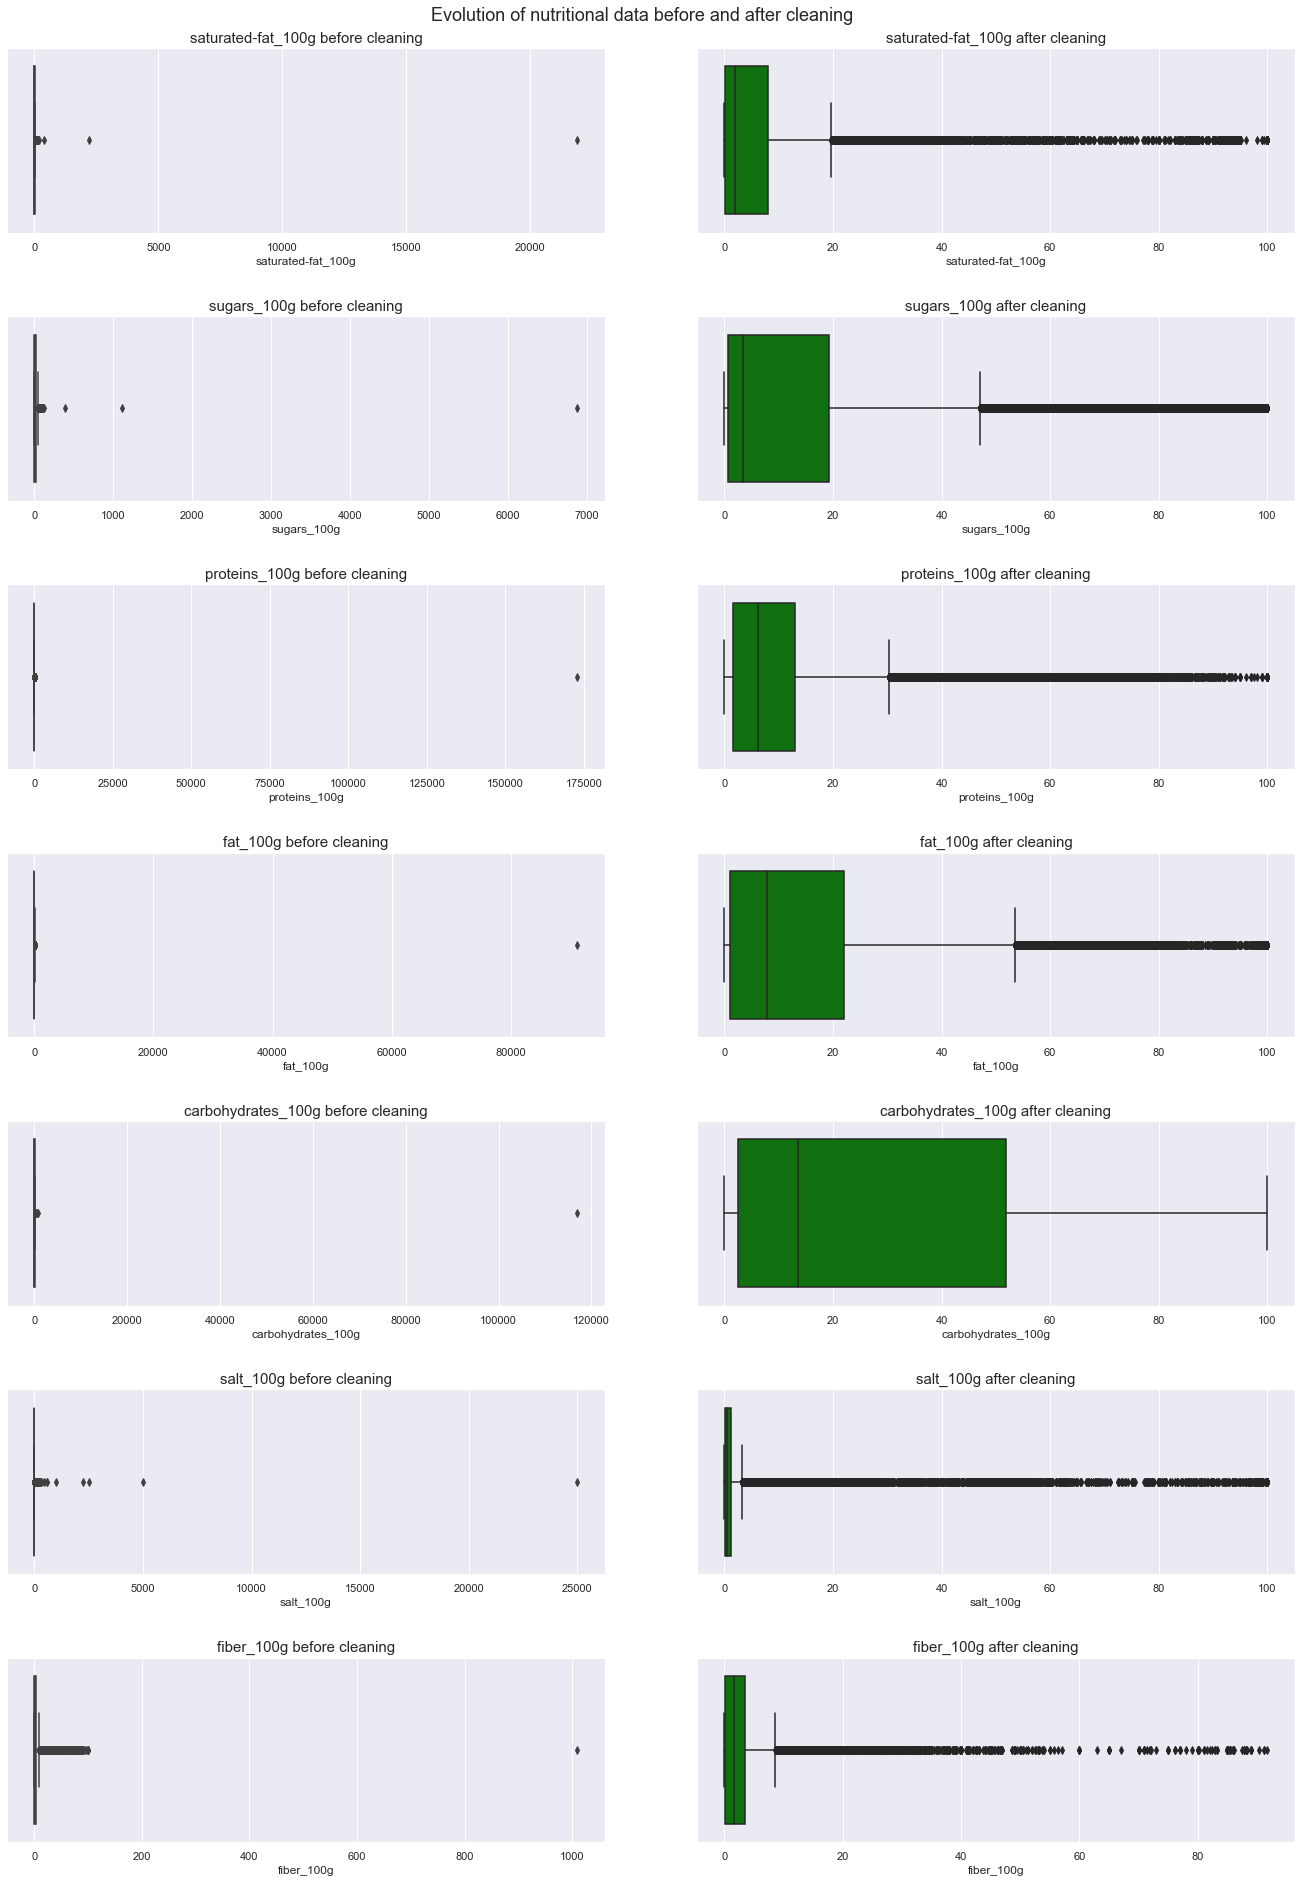

In [28]:
# First of all we convert the nutritional / nutriscore columns to numeric values
nutritional_columns = get_nutritional_columns(data_france, exclude_starts=['nutrition', 'energy'])
data_france[nutritional_columns] = data_france[nutritional_columns].apply(pd.to_numeric)

# Preparing the plot
fig, axs = plt.subplots(figsize=(20,4*len(nutritional_columns)), ncols=2, nrows=len(nutritional_columns))
fig.suptitle('Evolution of nutritional data before and after cleaning', fontsize=18, y=0.95)
fig.tight_layout(pad=5.0)

# Then we clean them
for index, column in enumerate(nutritional_columns):
    data_france.loc[data_france[column] > 100, column] = np.nan
    data_france.loc[data_france[column] < 0, column] = np.nan
    
    axs[index][0].set_title(column + ' before cleaning', fontsize=15)
    sns.boxplot(x=nutri_data_before[column], ax=axs[index][0], color="firebrick")
    
    axs[index][1].set_title(column + ' after cleaning', fontsize=15)
    sns.boxplot(x=data_france[column], ax=axs[index][1], color="green") 

What can we notice here ?

* The boxplots for fats/saturated fats, proteins, and cabohydrates/sugars contains manu outliers but it's not surprising, because there exists many highly-sweet, highly-fat and higly-proteined products.
* The boxplots for salt is strange, because higly-salted product (more than 40% of salt) are mainly salt-based or bouillon products, and they are not as common as the boxplot can let us think. 
* Same thing for fiber boxplot : higly-fibered products (more than 40%) are very unusual so they shouldn't be that abundant.

**Conclusion** : for the moment, we let all this atypical values in the dataset and we will decide what we do about it later.

## 7. Treating missing values<a name="missing_values"></a>
### 7.1 Removing completely empty lines<a name="missing_empty_lines"></a>

In [29]:
# We removed the column "url" that is 100% filled
subset_columns = data_france.columns.values.tolist()
subset_columns.remove('url')
data_france = data_france.dropna(how="all", subset=subset_columns)

# Saving the new data length for filter history
applied_filters['Empty lines'] = len(data_france)

### 7.2 Removing products with no product name <a name="empty_product_names"></a>
These columns cannot contains aberrant values because they are only used for display, but they can contain missing values. 
For URL and image URL it's not a problem, but **we do want to have a product name** for our application.
That's why I decide to **remove all the product that don't have a product name (NaN or empty string)**

In [30]:
data_france = data_france[(data_france['product_name'].notnull()) & (data_france['product_name'].str.contains('^\s*$') == False)]

# Saving the new data length for filter history
applied_filters['No product name'] = len(data_france)

### 7.3 Removing product with too many missing nutritional data <a name="empty_nutritional"></a>
The nutritional data are essential to our application idea because : 
* we will use it to **calculate the missing nutrition scores** using a KNN algorithm.
* we will **display them in a spider chart** to easily compare the selected similar products.

But we don't have to remove any line having one missing nutritional information because we can impute them using linear regression between columns.

The idea here is to check how many missing nutritional values we have over the 7 selected ones and choose which rows to remove.

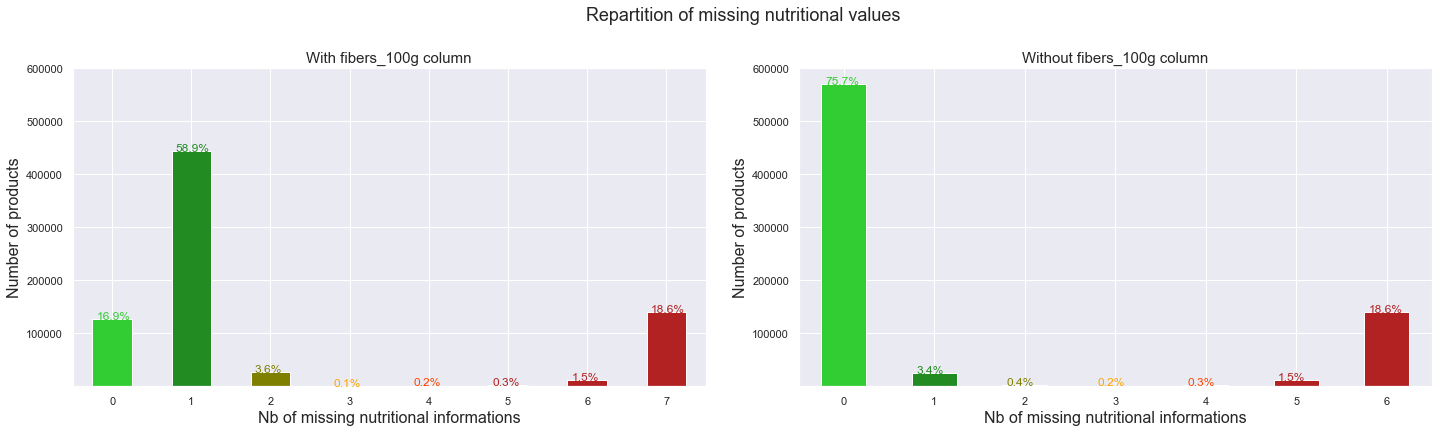

In [31]:
nutritional_columns = get_nutritional_columns(data_france, exclude_starts=['nutrition', 'energy'])
nutritional_columns_no_fiber = get_nutritional_columns(data_france, exclude_starts=['nutrition', 'energy', 'fiber'])

missing_nutritional_info = data_france[nutritional_columns].isna().sum(axis=1).to_frame()
missing_nutritional_info.columns = ['missing values']

missing_nutritional_info_no_fiber = data_france[nutritional_columns_no_fiber].isna().sum(axis=1).to_frame()
missing_nutritional_info_no_fiber.columns = ['missing values']

colors = ["limegreen", "forestgreen", "olive", "orange", "orangered", "firebrick", "firebrick", "firebrick"]

fig, axes = plt.subplots(figsize=(20,6), ncols=2)
fig.suptitle("Repartition of missing nutritional values", fontsize=18)
fig.tight_layout(pad=2, w_pad=5)

axes[0].set_title("With fibers_100g column", fontsize=15)
missing_nutritional_info.value_counts().sort_index().plot(kind="bar", logy=False, color=colors, ax=axes[0])

axes[1].set_title("Without fibers_100g column", fontsize=15)
missing_nutritional_info_no_fiber.value_counts().sort_index().plot(kind="bar", logy=False, color=colors, ax=axes[1])

for ax in axes:
    ax.set_xlabel("Nb of missing nutritional informations", fontsize=16)
    ax.set_ylabel("Number of products", fontsize=16)
    ax.set_ylim(ymin=100, ymax=600000)
    
for index, value in enumerate(missing_nutritional_info.value_counts().sort_index()):
    axes[0].set_xticklabels(labels=range(len(missing_nutritional_info.value_counts())), rotation=0)
    axes[0].text(index-0.2, value, str(round(100*value/len(data_france),1)) + "%", color=colors[index])
    
for index, value in enumerate(missing_nutritional_info_no_fiber.value_counts().sort_index()):
    axes[1].set_xticklabels(labels=range(len(missing_nutritional_info_no_fiber.value_counts())), rotation=0)
    axes[1].text(index-0.2, value, str(round(100*value/len(data_france),1)) + "%", color=colors[index])

We notice here a **very important thing** : as the *fiber_100g* column is very poorly filled (around 83% of NaN) it introduces at least one missing nutritional value in 83% of the product. We can see that without the fiber column, **75% of the product have all their nutritional informations completed**.

That's why **we keep the fibers column** for our application (it will allow us to display it for product posessing it) but **we will ignore it in the exploratory analysis** (second notebook).

On the other hand, we can **remove all the products with 3 missing nutritional values or more** (without the fiber) because we already know we won't be able to impute them all without introducing a bias.

In [32]:
data_france['missing_nutritional_values'] = data_france[nutritional_columns_no_fiber].isna().sum(axis=1)
data_france = data_france[data_france['missing_nutritional_values'] < 3]
data_france = data_france.drop('missing_nutritional_values', axis="columns")

# Saving the new data length for filter history
applied_filters['Too many \nmissing info'] = len(data_france)

### 7.4 Removing product with neither a category nor tags <a name="missing_categories"></a>
Because we are going to use it to pre-select the similar products to improve calculation time.

In [33]:
data_france = data_france[(data_france['main_category'].notnull()) | (data_france['categories_tags'].notnull())]

# Saving the new data length for filter history
applied_filters['No category/tags'] = len(data_france)

### 7.5 Filling other missing values <a name="missing_others"></a>
There are still 2 process to fill missing values, but we will apply them **after the exploratory analysis of the second notebook** in order to no 
* Filling missing nutritional values using the mean values of products with the same main category
* Filling missing nutriscore/nutrigrade using a k-NN model

### 7.6 Summary of data cleaning
Here is a plot summarizing all the cleaning process we went through on this file : 


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

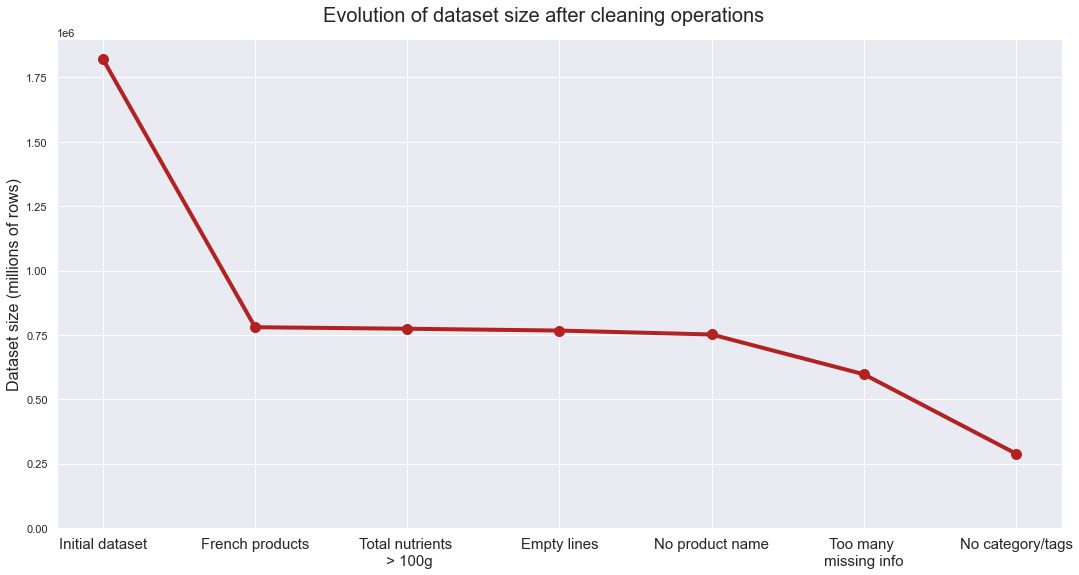

In [34]:
fig = plt.figure(figsize=(18,9))
fig.suptitle("Evolution of dataset size after cleaning operations", fontsize=20, y=0.93)
fig.gca().set_ylim(ymin=0, ymax=1900000)
fig.gca().set_ylabel("Dataset size (millions of rows)", fontsize=16)
plt.plot(applied_filters.keys(), applied_filters.values(), linewidth=4, color="firebrick", marker="o", markersize=10)
plt.xticks(fontsize=15)

## 8. Exporting the cleaned data<a name="export"></a>

In [35]:
exported_data = data_france.copy(deep=True).reset_index().drop('index', axis="columns")
exported_data.to_csv('data/off_cleaned_data.csv', sep='\t')

print(str(len(exported_data)) + " lines have been exported successfully.")

289200 lines have been exported successfully.
